Implementing the U Net architecture

Steps:
1. Get the data
2. May have to preprocess (add augmentation, clean etc.)
3. Create test, train sets and dataloaders
4. Create a model
5. Train

In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np


Getting the data:

Using git

In [ ]:
# Clone the repository
!git clone https://github.com/shimchu/carvana-dataset

# Change directory to the dataset folder
%cd carvana-dataset



Cloning into 'carvana-dataset'...
remote: Enumerating objects: 10183, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 10183 (delta 0), reused 3 (delta 0), pack-reused 10180 (from 1)
Receiving objects: 100% (10183/10183), 436.05 MiB | 32.57 MiB/s, done.
Updating files: 100% (10177/10177), done.
/content/carvana-dataset


In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms


In [ ]:

class CarvanaDataset(Dataset):
    def __init__(self, images_path, masks_path, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform
        self.images = os.listdir(images_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.images_path, img_name)
        mask_path = os.path.join(self.masks_path, img_name.replace('.jpg', '_mask.gif'))

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Set paths
train_images_path = './train'
train_masks_path = './train_masks'

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),                                      #resize
    transforms.ToTensor()
])

# Create the full dataset
full_dataset = CarvanaDataset(train_images_path, train_masks_path, transform=transform)

# Define the split ratio
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split the dataset
# torch.manual_seed(42)
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=False, num_workers=2)

# Check a batch of data from the train loader
images, masks = next(iter(train_loader))
print(images.shape, masks.shape)

# Check a batch of data from the test loader
test_images, test_masks = next(iter(test_loader))
print(test_images.shape, test_masks.shape)


Train dataset size: 4070
Test dataset size: 1018
torch.Size([64, 1, 128, 128]) torch.Size([64, 1, 128, 128])
torch.Size([64, 1, 128, 128]) torch.Size([64, 1, 128, 128])


In [ ]:
import matplotlib.pyplot as plt
def show_example_image_and_mask(dataset, idx=0):
    # Get the image and mask from the dataset
    image, mask = dataset[idx]
    print(image.shape,  mask.shape)
    # Convert tensors to numpy arrays for visualization
    image_np = image.squeeze(0).numpy() if image.shape[0] == 1 else np.transpose(image.numpy(), (1, 2, 0))
    mask_np = mask.squeeze(0).numpy()

    # Plot the image and its corresponding mask
    plt.figure(figsize=(10, 5))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(image_np, cmap='gray' if image_np.ndim == 2 else None)
    plt.title("Image")
    plt.axis("off")

    # Display the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='gray')
    plt.title("Mask")
    plt.axis("off")

    plt.show()


torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


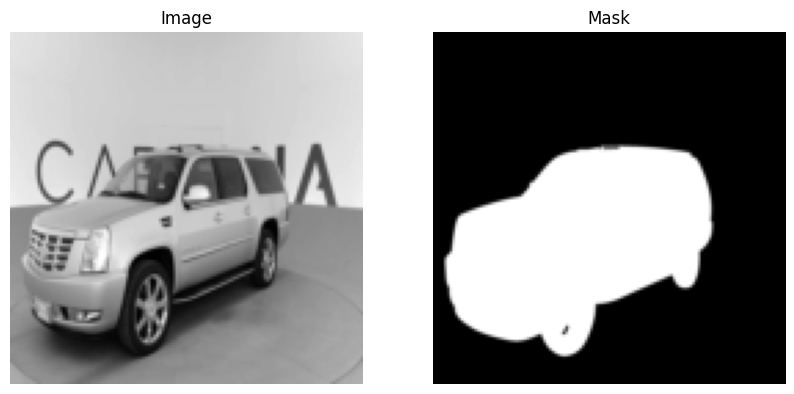

In [ ]:
show_example_image_and_mask(train_dataset)

In [ ]:

import os

train_dir = './train'
train_masks_dir = './train_masks'

num_train_images = len([name for name in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, name))])
num_train_masks = len([name for name in os.listdir(train_masks_dir) if os.path.isfile(os.path.join(train_masks_dir, name))])

print(f"Number of images in train folder: {num_train_images}")
print(f"Number of images in train_masks folder: {num_train_masks}")

Number of images in train folder: 5088
Number of images in train_masks folder: 5088


MODEL:

In [ ]:
import torch
import torch.nn as nn


In [ ]:
def double_conv(in_c,  out_c):
  conv = nn.Sequential(
      nn.Conv2d(in_c, out_c, kernel_size = 3, padding = 1),
      nn.ReLU(inplace = True),
      nn.Conv2d(out_c, out_c, kernel_size = 3, padding = 1),    ##padding = 1 is not there in original paper but done to ensure same input and output siz
      nn.ReLU(inplace = True)
  )
  return conv


def crop_img(tensor, target_tensor):
  target_size = target_tensor.size()[2]
  tensor_size = tensor.size()[2]
  delta = tensor_size - target_size
  delta = delta//2
  return tensor[:, :, delta: tensor_size - delta, delta: tensor_size - delta]

class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()

    self.max_pool_2x2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.down_conv_1 = double_conv(1, 64)
    self.down_conv_2 = double_conv(64, 128)
    self.down_conv_3 = double_conv(128, 256)
    self.down_conv_4 = double_conv(256, 512)
    self.down_conv_5 = double_conv(512, 1024)    ###Bottle neck


    self.up_trans_1 = nn.ConvTranspose2d(in_channels  = 1024, out_channels = 512, kernel_size = 2, stride = 2)
    self.up_conv_1 = double_conv(1024, 512)
    self.up_trans_2 = nn.ConvTranspose2d(in_channels  = 512, out_channels = 256, kernel_size = 2, stride = 2)
    self.up_conv_2 = double_conv(512, 256)
    self.up_trans_3 = nn.ConvTranspose2d(in_channels  = 256, out_channels = 128, kernel_size = 2, stride = 2)
    self.up_conv_3 = double_conv(256, 128)
    self.up_trans_4 = nn.ConvTranspose2d(in_channels  = 128, out_channels = 64, kernel_size = 2, stride = 2 )
    self.up_conv_4 = double_conv(128, 64)

    self.out = nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size = 1)

  def forward(self, image):     #automatically runs as __call__ is implented when model(image) this command is passed
    #bs, c, h, w
    #encoder
    x1 = self.down_conv_1(image)
    # print(x1.size())
    x2 = self.max_pool_2x2(x1)
    x3 = self.down_conv_2(x2)
    x4 = self.max_pool_2x2(x3)
    x5 = self.down_conv_3(x4)
    x6 = self.max_pool_2x2(x5)
    x7 = self.down_conv_4(x6)
    x8 = self.max_pool_2x2(x7)
    x9 = self.down_conv_5(x8)
    # print(x9.size())

    #decoder

    x = self.up_trans_1(x9)
    # print(x.size())
    y = crop_img(x7, x)
    x = self.up_conv_1(torch.cat([x, y], 1))

    x = self.up_trans_2(x)
    y = crop_img(x5, x)
    x = self.up_conv_2(torch.cat([x,y], 1))

    x = self.up_trans_3(x)
    y = crop_img(x3, x)
    x = self.up_conv_3(torch.cat([x,y],
                                 ))

    x = self.up_trans_4(x)
    y = crop_img(x1, x)
    x = self.up_conv_4(torch.cat([x,y], 1))
    # print(x.size())



    x = self.out(x)
    # print(x.size())
    return x


image = torch.rand((1, 1, 128, 128))
model = UNet()
print(model(image))
# model.forward(image)


tensor([[[[-0.0167, -0.0193, -0.0197,  ..., -0.0191, -0.0178, -0.0214],
          [-0.0178, -0.0215, -0.0233,  ..., -0.0223, -0.0180, -0.0214],
          [-0.0182, -0.0213, -0.0196,  ..., -0.0224, -0.0184, -0.0228],
          ...,
          [-0.0188, -0.0185, -0.0226,  ..., -0.0216, -0.0192, -0.0186],
          [-0.0190, -0.0186, -0.0240,  ..., -0.0212, -0.0182, -0.0213],
          [-0.0154, -0.0190, -0.0216,  ..., -0.0213, -0.0190, -0.0179]]]],
       grad_fn=<ConvolutionBackward0>)


In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
summary(model, input_size = [1,1,128, 128])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 1, 128, 128]          --
├─Sequential: 1-1                        [1, 64, 128, 128]         --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         640
│    └─ReLU: 2-2                         [1, 64, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 64, 128, 128]         36,928
│    └─ReLU: 2-4                         [1, 64, 128, 128]         --
├─MaxPool2d: 1-2                         [1, 64, 64, 64]           --
├─Sequential: 1-3                        [1, 128, 64, 64]          --
│    └─Conv2d: 2-5                       [1, 128, 64, 64]          73,856
│    └─ReLU: 2-6                         [1, 128, 64, 64]          --
│    └─Conv2d: 2-7                       [1, 128, 64, 64]          147,584
│    └─ReLU: 2-8                         [1, 128, 64, 64]          --
├─MaxPool2d: 1-4                         [1, 128, 32, 32]          --
├

Train:

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import torch.optim as optim
from tqdm.auto import tqdm
from timeit import default_timer as timer
start_time = timer()

model = UNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 20  # Set the number of epochs as 22

for epoch in tqdm(range(num_epochs)):
    model.train()
    training_running_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        optimizer.zero_grad()
        loss = criterion(outputs, masks)
        training_running_loss += loss.item()
        loss.backward()
        optimizer.step()



    epoch_loss = training_running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    # Optional: Evaluate the model on the test set
    model.eval()
    test_loss = 0.0
    test_corrects = 0
    test_total_pixels = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            # Resize the masks to match the output size
            masks_resized = torch.nn.functional.interpolate(masks, size=(outputs.size(2), outputs.size(3)), mode='bilinear', align_corners=False)

            loss = criterion(outputs, masks_resized)
            test_loss += loss.item() * images.size(0)

            # Calculate accuracy
            preds = outputs > 0.5
            test_corrects += torch.sum(preds == masks_resized)
            test_total_pixels += masks_resized.numel()

        epoch_test_loss = test_loss / len(test_loader.dataset)
        epoch_test_acc = test_corrects.double() / test_total_pixels
        print(f'Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {epoch_test_acc:.4f}')



# Save the trained model
torch.save(model.state_dict(), 'unet_carvana.pth')

# End the timer and print out how long it took
end_time = timer()
print(timer())

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.0077
Test Loss: 0.3681, Test Accuracy: 0.7738
Epoch 2/20, Loss: 0.0028
Test Loss: 0.1039, Test Accuracy: 0.9410
Epoch 3/20, Loss: 0.0015
Test Loss: 0.0764, Test Accuracy: 0.9491
Epoch 4/20, Loss: 0.0011
Test Loss: 0.0622, Test Accuracy: 0.9550
Epoch 5/20, Loss: 0.0009
Test Loss: 0.0465, Test Accuracy: 0.9595
Epoch 6/20, Loss: 0.0007
Test Loss: 0.0403, Test Accuracy: 0.9624
Epoch 7/20, Loss: 0.0006
Test Loss: 0.0388, Test Accuracy: 0.9625
Epoch 8/20, Loss: 0.0006
Test Loss: 0.0359, Test Accuracy: 0.9636
Epoch 9/20, Loss: 0.0006
Test Loss: 0.0367, Test Accuracy: 0.9644
Epoch 10/20, Loss: 0.0005
Test Loss: 0.0313, Test Accuracy: 0.9658
Epoch 11/20, Loss: 0.0005
Test Loss: 0.0294, Test Accuracy: 0.9661
Epoch 12/20, Loss: 0.0005
Test Loss: 0.0299, Test Accuracy: 0.9657


KeyboardInterrupt: 

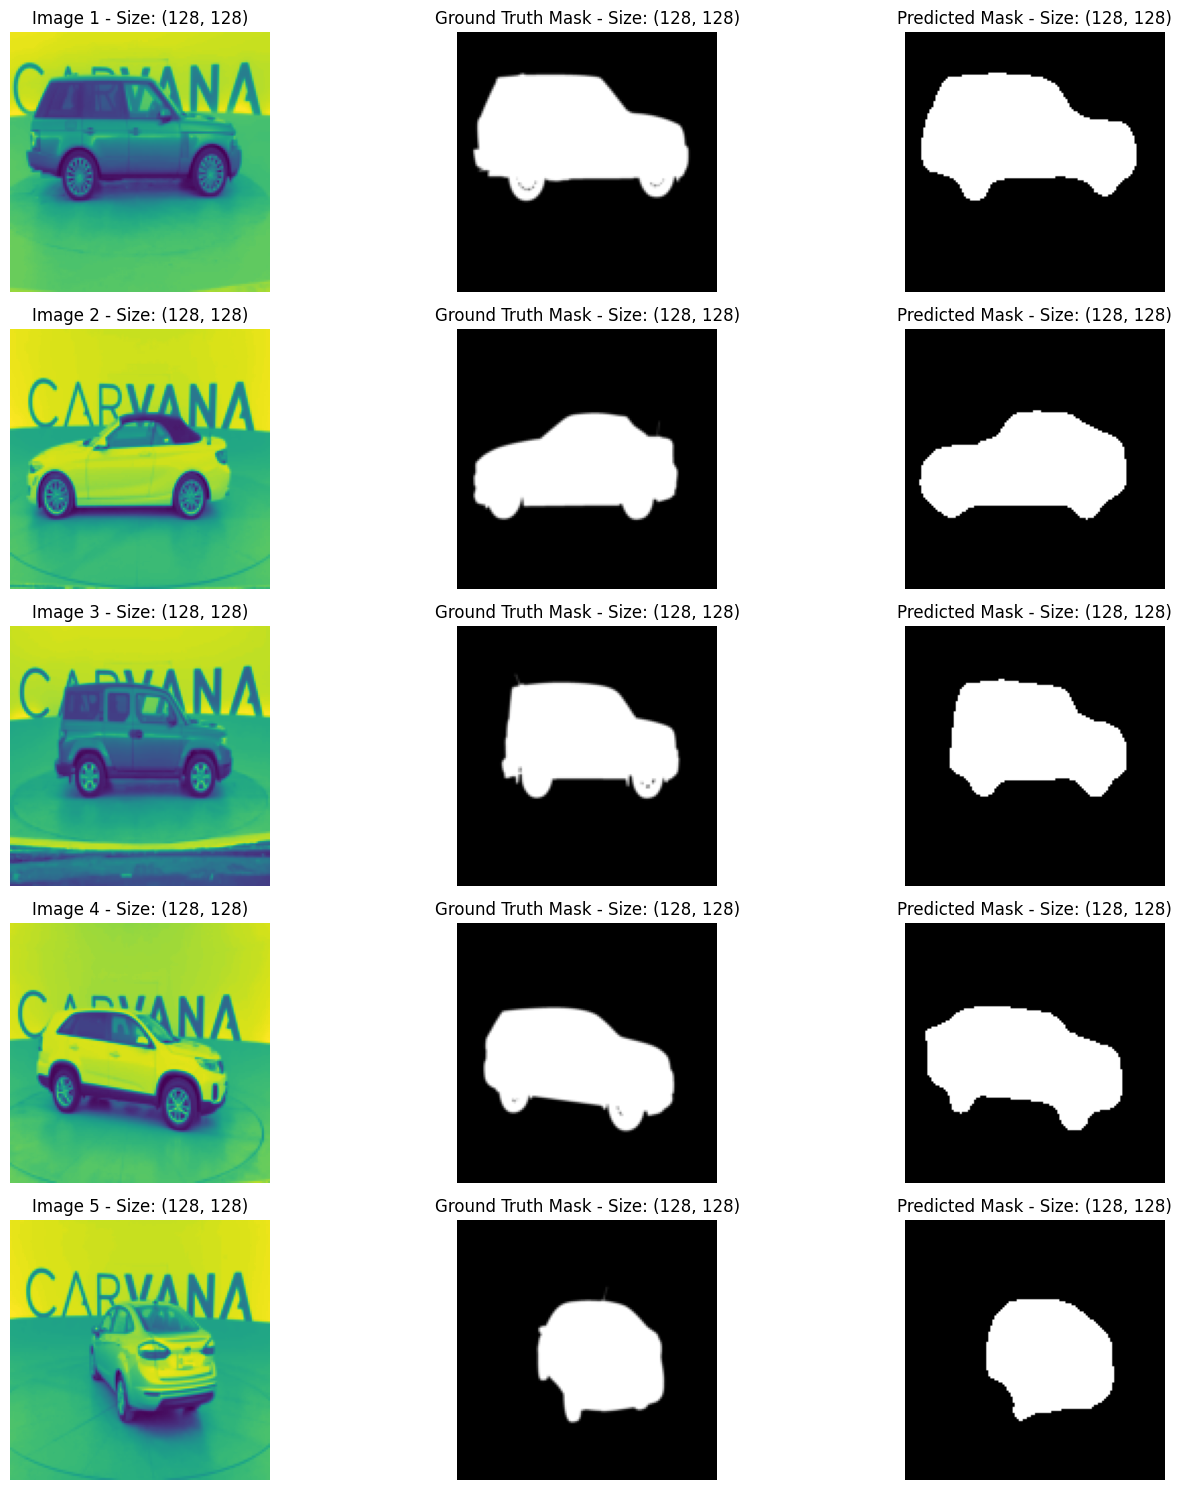

In [ ]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Function to visualize images, masks, and predictions
def visualize_random_images(model, dataset, num_images=5):
    # Set the model to evaluation mode
    model.eval()

    # Select random images and their masks
    random_indices = random.sample(range(len(dataset)), num_images)

    fig, axs = plt.subplots(num_images, 3, figsize=(15, 15))

    for i, idx in enumerate(random_indices):
        # Get the image and mask from dataset
        image, mask = dataset[idx]

        # Add batch dimension and move to device
        image = image.unsqueeze(0).to(device)

        # Predict mask
        with torch.no_grad():
            output = model(image)
            predicted_mask = torch.sigmoid(output).squeeze(0)
            predicted_mask = (predicted_mask > 0.5).float()  # Threshold at 0.5

        # Convert tensors to numpy arrays for visualization
        image_np = TF.to_pil_image(image.cpu().squeeze(0))
        mask_np = TF.to_pil_image(mask.cpu())
        predicted_mask_np = TF.to_pil_image(predicted_mask.cpu())

        # Display original image, ground truth mask, and predicted mask
        axs[i, 0].imshow(image_np)
        axs[i, 0].set_title(f"Image {i+1} - Size: {image_np.size}")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(mask_np, cmap='gray')
        axs[i, 1].set_title(f"Ground Truth Mask - Size: {mask_np.size}")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(predicted_mask_np, cmap='gray')
        axs[i, 2].set_title(f"Predicted Mask - Size: {predicted_mask_np.size}")
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Usage example
visualize_random_images(model, test_dataset)